<a href="https://colab.research.google.com/github/shafkat2/Industrial_Development_A.I/blob/master/Third%20Phase/Caption_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from PIL import Image
import glob
import re
from random import *
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.models import Model
from keras.models import load_model
from numpy import argmax
import cv2
import matplotlib.pyplot as plt
from keras.layers import Bidirectional

Using TensorFlow backend.


# ***Creating Captions***

In [0]:
image_list = {}                                                                      #dictionary for image and caption
captions = []                                                                        # captions array
for filename in glob.glob('/content/drive/My Drive/Colab_Notebooks/devImg/*.jpg'):      #assuming gif
    img=Image.open(filename)                                                         #loading the image                                                                #the take the filename 
    Unique = int(re.sub("\D", "", filename ))                                        #removing all the letters to create unique ID
    print(Unique)
    if Unique < 15 or ( Unique <368  and Unique >= 359) :
      caption1 = "pan empty and no egg";                                             #defining captions
      caption2 = "no egg and pan empty";   
      captions = [caption1,caption2]                                                 # assigning captions array
      image_list.update({Unique:[img,captions]})                                     # creating the dictionary of images with captions and uniques key
    elif (Unique <66 and Unique >= 15) or ( Unique <403  and Unique >= 368):
      caption1 = "egg grabbed and pan empty";
      caption2 = "pan empty and grabbed egg";
      captions = [caption1,caption2]
      image_list.update({Unique:[img,captions]})
    elif (Unique <163 and Unique >= 66) or ( Unique <467 and Unique >= 403):
      caption1 = "drop egg on pan hand over pan";
      caption2 = "hand over pan and egg drop on pan";
      captions = [caption1,caption2]
      image_list.update({Unique:[img,captions]})
    elif (Unique <215 and Unique >= 163) or ( Unique <516  and Unique >= 467):
      caption1 = "egg on pan and hand over pan";
      caption2 = "hand over pan and egg on pan";
      captions = [caption1,caption2]
      image_list.update({Unique:[img,captions]})
    elif (Unique <245 and Unique >=215) or ( Unique <585  and Unique >= 516) or ( Unique <= 342  and Unique >= 305):
      caption1 = "egg on pan";
      caption2 = "pan has egg"; 
      captions = [caption1,caption2]
      image_list.update({Unique:[img,captions]})
    elif (Unique <305 and Unique >=245) or  ( Unique <650  and Unique >= 516)  :
      caption1 = "egg on pan and hand over egg";
      caption2 = "hand over egg and pan has egg"; 
      captions = [caption1,caption2]
      image_list.update({Unique:[img,captions]}) 
    


# ***Helper Funnctions***

In [0]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list[1]:
			lines.append(str(key) + ' ' + desc)
	data = '\n'.join(lines)
	file = open('/content/drive/My Drive/Colab_Notebooks/'+filename, 'w')
	file.write(data)
	file.close()

# ***Extracting Features from image***

In [0]:
def extract_features(directory):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# summarize
	print(model.summary())
	# extract features from each photo
	features = dict()
	for image_id,image in directory.items():
		image = image[0].resize((224,224), Image.ANTIALIAS)
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get features
		feature = model.predict(image, verbose=0)
		# store feature
		features[image_id] = feature
		print('>%s' % image_id)
	return features

# ***Load description and features from file***

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


# load clean descriptions into memory
def load_clean_descriptions(filename):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		# create list
		if image_id not in descriptions:
			descriptions[image_id] = list()
		# wrap description in tokens
		desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
		# store
		descriptions[image_id].append(desc)
	return descriptions

In [0]:
def load_photo_features(filename):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	#features = {k: all_features[k] for k in dataset}
	return all_features

# ***Tokenizing Descriptions***

In [0]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 


# ***Creating sequence for LSTM***

In [0]:
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        
				X1.append(photos[int(key)][0])
				X2.append(in_seq)
				y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)


# ***LSTM MODEL***

In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.7)(se1)
	se3 = Bidirectional(LSTM(128,recurrent_dropout= 0.3))(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# ***Extracting feature and description***

In [0]:
save_descriptions(image_list,"desciption_dev.txt")

In [0]:
features = extract_features(image_list)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('/content/drive/My Drive/Colab_Notebooks/features_dev.pkl', 'wb'))

# ***Making train set***

In [10]:
train_descriptions = load_clean_descriptions('/content/drive/My Drive/Colab_Notebooks/desciption.txt')
print('Descriptions: train=%d' % len(train_descriptions))
#photo features
train_features = load_photo_features('/content/drive/My Drive/Colab_Notebooks/features.pkl')
print('Photos: train=%d' % len(train_features))
print(train_features[0][0])

Descriptions: train=693
Photos: train=693
[0.        0.        0.5894369 ... 0.        0.        2.3999982]


In [11]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)


Vocabulary Size: 14
Description Length: 10


In [0]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

# ***Making Validation Set***

In [0]:
train_descriptions_dev = load_clean_descriptions('/content/drive/My Drive/Colab_Notebooks/desciption_dev.txt')
print('Descriptions: train=%d' % len(train_descriptions_dev))
#photo features
train_features_dev = load_photo_features('/content/drive/My Drive/Colab_Notebooks/features_dev.pkl')
print('Photos: train=%d' % len(train_features_dev))
print(train_features[0][0])

Descriptions: train=311
Photos: train=311
[0.        0.        0.5894369 ... 0.        0.        2.3999982]


In [0]:
X1test, X2test, ytest = create_sequences(tokenizer, max_length, train_descriptions_dev, train_features_dev, vocab_size)

# ***Training Model***

In [0]:


# define the model
model = define_model(vocab_size, max_length)
# define checkpoint callback
filepath = '/content/drive/My Drive/Colab_Notebooks/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 10, 256)      3584        input_59[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 4096)         0           input_58[0][0]                   
___________________________________________________________________________________________

# ***Generating Captions***

In [0]:
def extract_features_test(filename):
	# load the model
	model = VGG16()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [0]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [0]:
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

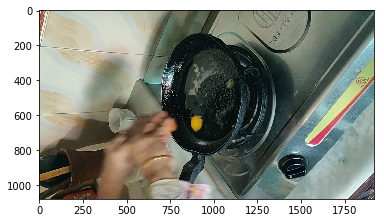

startseq egg on pan endseq


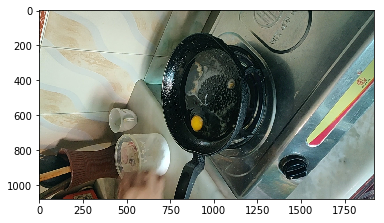

startseq egg on pan endseq


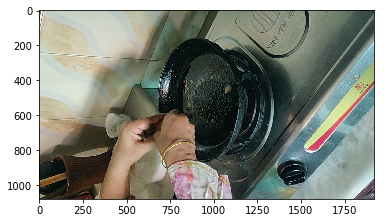

startseq hand over pan and egg drop on pan endseq


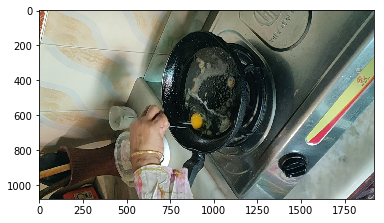

startseq egg on pan and hand over pan endseq


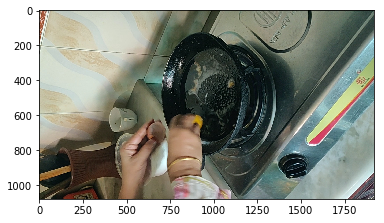

startseq hand over pan and egg on pan endseq


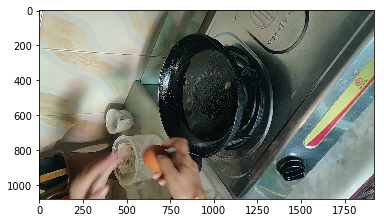

startseq hand over pan and egg on pan endseq


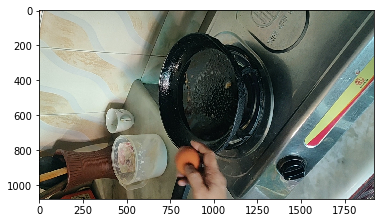

startseq hand over pan and egg on pan endseq


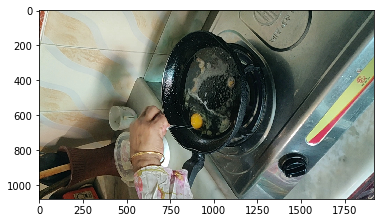

startseq egg on pan and hand over pan endseq


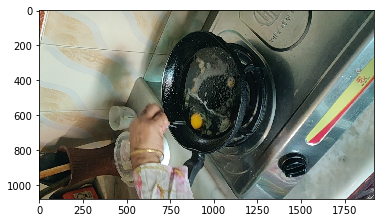

startseq egg on pan endseq


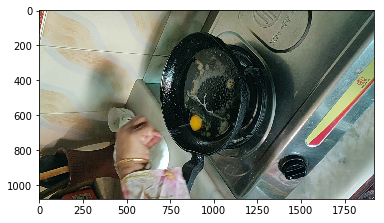

startseq hand over pan and egg on pan endseq


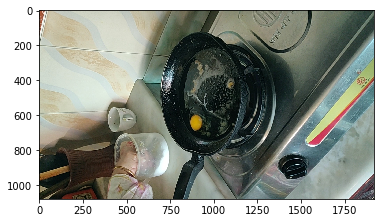

startseq egg on pan endseq


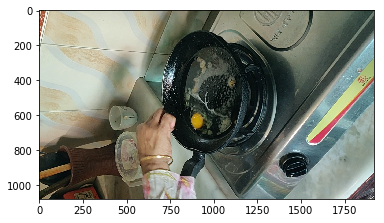

startseq egg on pan endseq


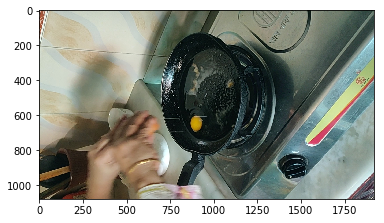

startseq egg on pan endseq


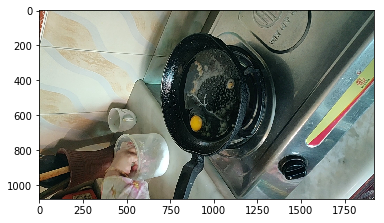

startseq hand over egg and pan has egg endseq


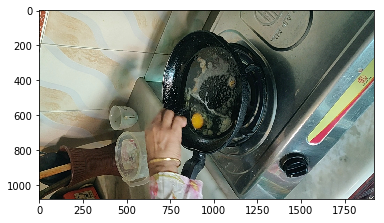

startseq hand over pan and egg on pan endseq


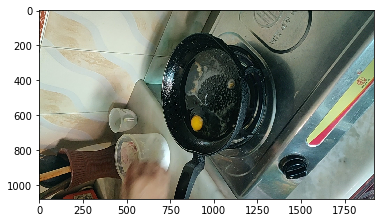

startseq egg on pan and hand over pan endseq


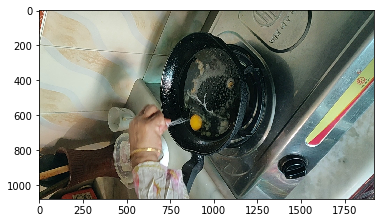

startseq egg on pan endseq


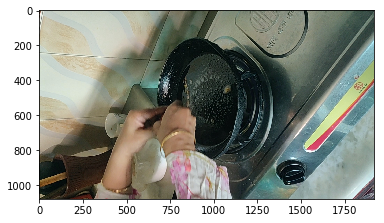

startseq hand over pan and egg drop on pan endseq


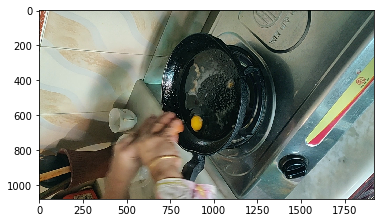

startseq hand over pan and egg on pan endseq


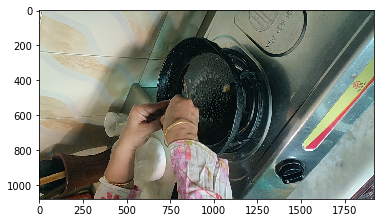

startseq hand over pan and egg drop on pan endseq


In [20]:
# load the tokenizer
#tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 10
# load the model
model = load_model('/content/drive/My Drive/Colab_Notebooks/model-ep004-loss0.155-val_loss0.315.h5')
# load and prepare the photograph
for x in range(0,20):
  picRand = str(randint(50,300))
  Pictures =Image.open('/content/drive/My Drive/Colab_Notebooks/devImg/'+picRand+'.jpg')
  plt.imshow(Pictures)
  plt.show()
  
  photo = extract_features_test('/content/drive/My Drive/Colab_Notebooks/devImg/'+picRand+'.jpg')
  # generate description
  
  description = generate_desc(model, tokenizer, photo, max_length)
  print(description)